## Random Forest Importance

In [33]:
import pandas as pd
df = pd.read_csv('./data/processed_mrna_zscore.csv')

In [34]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

In [36]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt


def rf_importance(X_train,y_train,max_depth=10,class_weight=None,top_n=15,n_estimators=50,random_state=0):
    
    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                    random_state=random_state,class_weight=class_weight,
                                    n_jobs=-1)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_labels = X_train.columns
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0) #  inter-trees variability. 

    # plotting
    indices = indices[0:top_n]
    plt.figure()
    plt.title("Feature importances top %d" % top_n)
    plt.bar(range(top_n), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(top_n), feat_labels[indices], rotation=90)
    plt.xlim([-1,top_n])
    plt.show() 
    print(f"Top {top_n} features: ", feat_labels[indices])
    return feat_labels[indices]

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


def k_fold(X, y, classifier, k_folds=10):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)

    weighted_accuracies = []

    i = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTE on the training set
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the classifier on the resampled data
        classifier.fit(X_resampled, y_resampled)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Calculate and store the weighted accuracy
        weighted_accuracy = accuracy_score(y_test, y_pred, sample_weight=None)  # You may need to adjust the sample_weight parameter
        weighted_accuracies.append(weighted_accuracy)
        # Calculate accuracy for each class
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_accuracies = {int(class_label): report['precision'] for class_label, report in class_report.items() if class_label.isdigit()}
        print(f"\nFold {i+1} - Class-wise Accuracies:")
        print(class_report)

        print(f"Fold {i+1} : {weighted_accuracy}")
        i+=1

    # Calculate the average weighted accuracy
    average_weighted_accuracy = np.mean(weighted_accuracies)
    print("Average Weighted Accuracy:", average_weighted_accuracy)
    return average_weighted_accuracy
    

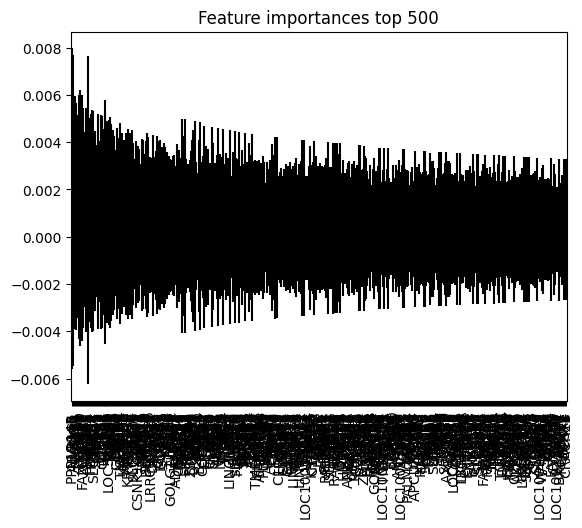

Top 500 features:  Index(['PPP1R14B', 'NUP155', 'ADGRG1', 'SKP2', 'GSDMB', 'NOP10', 'HPS1',
       'GREB1', 'CCNB2', 'TMEM99',
       ...
       'LOC100130051', 'ADD2', 'OCM2', 'BX648270', 'ARAP1', 'PCYOX1L', 'HOXA2',
       'P4HA2', 'DCST1', 'CRACR2B'],
      dtype='object', length=500)


In [42]:
selected_feats = rf_importance(X_train=X, y_train=y, n_estimators=100, max_depth=100, top_n=500)

In [43]:
scores = k_fold(classifier=RandomForestClassifier(n_estimators=100, n_jobs=-1), 
                X=X[selected_feats], y=y)
scores

/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 - Class-wise Accuracies:
{'long': {'precision': 0.8716577540106952, 'recall': 0.9532163742690059, 'f1-score': 0.9106145251396649, 'support': 171.0}, 'medium': {'precision': 0.2, 'recall': 0.09523809523809523, 'f1-score': 0.12903225806451613, 'support': 21.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'accuracy': 0.8375634517766497, 'macro avg': {'precision': 0.3572192513368984, 'recall': 0.34948482316903373, 'f1-score': 0.34654892773472695, 'support': 197.0}, 'weighted avg': {'precision': 0.7779364260701973, 'recall': 0.8375634517766497, 'f1-score': 0.8041866051687184, 'support': 197.0}}
Fold 1 : 0.8375634517766497


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 - Class-wise Accuracies:
{'long': {'precision': 0.8829787234042553, 'recall': 0.9707602339181286, 'f1-score': 0.924791086350975, 'support': 171.0}, 'medium': {'precision': 0.3333333333333333, 'recall': 0.14285714285714285, 'f1-score': 0.2, 'support': 21.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'accuracy': 0.8578680203045685, 'macro avg': {'precision': 0.4054373522458629, 'recall': 0.3712057922584238, 'f1-score': 0.37493036211699166, 'support': 197.0}, 'weighted avg': {'precision': 0.8019764553407496, 'recall': 0.8578680203045685, 'f1-score': 0.8240572373909477, 'support': 197.0}}
Fold 2 : 0.8578680203045685


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 - Class-wise Accuracies:
{'long': {'precision': 0.8711340206185567, 'recall': 0.9883040935672515, 'f1-score': 0.9260273972602739, 'support': 171.0}, 'medium': {'precision': 0.3333333333333333, 'recall': 0.047619047619047616, 'f1-score': 0.08333333333333333, 'support': 21.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'accuracy': 0.8629441624365483, 'macro avg': {'precision': 0.4014891179839633, 'recall': 0.34530771372876634, 'f1-score': 0.33645357686453575, 'support': 197.0}, 'weighted avg': {'precision': 0.7916950128211838, 'recall': 0.8629441624365483, 'f1-score': 0.8126938321396286, 'support': 197.0}}
Fold 3 : 0.8629441624365483


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 - Class-wise Accuracies:
{'long': {'precision': 0.8691099476439791, 'recall': 0.9764705882352941, 'f1-score': 0.9196675900277008, 'support': 170.0}, 'medium': {'precision': 0.3333333333333333, 'recall': 0.09090909090909091, 'f1-score': 0.14285714285714288, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'accuracy': 0.8527918781725888, 'macro avg': {'precision': 0.40081442699243747, 'recall': 0.35579322638146166, 'f1-score': 0.3541749109616146, 'support': 197.0}, 'weighted avg': {'precision': 0.7872183981360903, 'recall': 0.8527918781725888, 'f1-score': 0.8095753677541436, 'support': 197.0}}
Fold 4 : 0.8527918781725888


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 - Class-wise Accuracies:
{'long': {'precision': 0.873015873015873, 'recall': 0.9705882352941176, 'f1-score': 0.9192200557103063, 'support': 170.0}, 'medium': {'precision': 0.14285714285714285, 'recall': 0.045454545454545456, 'f1-score': 0.06896551724137931, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'accuracy': 0.8469387755102041, 'macro avg': {'precision': 0.3386243386243386, 'recall': 0.33868092691622104, 'f1-score': 0.3293951909838952, 'support': 196.0}, 'weighted avg': {'precision': 0.7732426303854875, 'recall': 0.8469387755102041, 'f1-score': 0.805023728826849, 'support': 196.0}}
Fold 5 : 0.8469387755102041


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 6 - Class-wise Accuracies:
{'long': {'precision': 0.868421052631579, 'recall': 0.9705882352941176, 'f1-score': 0.9166666666666667, 'support': 170.0}, 'medium': {'precision': 0.16666666666666666, 'recall': 0.045454545454545456, 'f1-score': 0.07142857142857144, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'accuracy': 0.8469387755102041, 'macro avg': {'precision': 0.3450292397660819, 'recall': 0.33868092691622104, 'f1-score': 0.32936507936507936, 'support': 196.0}, 'weighted avg': {'precision': 0.7719298245614036, 'recall': 0.8469387755102041, 'f1-score': 0.8030855199222547, 'support': 196.0}}
Fold 6 : 0.8469387755102041


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 7 - Class-wise Accuracies:
{'long': {'precision': 0.8709677419354839, 'recall': 0.9529411764705882, 'f1-score': 0.9101123595505618, 'support': 170.0}, 'medium': {'precision': 0.2, 'recall': 0.09090909090909091, 'f1-score': 0.12500000000000003, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'accuracy': 0.8367346938775511, 'macro avg': {'precision': 0.35698924731182796, 'recall': 0.34795008912655967, 'f1-score': 0.3450374531835206, 'support': 196.0}, 'weighted avg': {'precision': 0.7778801843317973, 'recall': 0.8367346938775511, 'f1-score': 0.8034137812428341, 'support': 196.0}}
Fold 7 : 0.8367346938775511


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 8 - Class-wise Accuracies:
{'long': {'precision': 0.8882978723404256, 'recall': 0.9823529411764705, 'f1-score': 0.9329608938547486, 'support': 170.0}, 'medium': {'precision': 0.5, 'recall': 0.18181818181818182, 'f1-score': 0.26666666666666666, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'accuracy': 0.8724489795918368, 'macro avg': {'precision': 0.46276595744680854, 'recall': 0.3880570409982174, 'f1-score': 0.39987585350713845, 'support': 196.0}, 'weighted avg': {'precision': 0.8265848892748588, 'recall': 0.8724489795918368, 'f1-score': 0.8391327480712956, 'support': 196.0}}
Fold 8 : 0.8724489795918368


/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 9 - Class-wise Accuracies:
{'long': {'precision': 0.8691099476439791, 'recall': 0.9764705882352941, 'f1-score': 0.9196675900277008, 'support': 170.0}, 'medium': {'precision': 0.2, 'recall': 0.045454545454545456, 'f1-score': 0.07407407407407407, 'support': 22.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'accuracy': 0.8520408163265306, 'macro avg': {'precision': 0.35636998254799307, 'recall': 0.3406417112299465, 'f1-score': 0.3312472213672583, 'support': 196.0}, 'weighted avg': {'precision': 0.7762688321401859, 'recall': 0.8520408163265306, 'f1-score': 0.8059853057874427, 'support': 196.0}}
Fold 9 : 0.8520408163265306

Fold 10 - Class-wise Accuracies:
{'long': {'precision': 0.8716577540106952, 'recall': 0.9588235294117647, 'f1-score': 0.9131652661064427, 'support': 170.0}, 'medium': {'precision': 0.2222222222222222, 'recall': 0.09523809523809523, 'f1-score': 0.13333333333333333, 'support': 21.0}, 'short': {'precision': 0.0, 'recall': 0.0, 'f1-sco

/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haily/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.850810628820056